# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Load & Prepare Data**

In [2]:
TRAIN_DIR = '/kaggle/input/animal-faces/afhq/train'
VAL_DIR = '/kaggle/input/animal-faces/afhq/val'

In [3]:
def create_dataframe(dir_name):
    images = []
    labels = []
    folds = os.listdir(dir_name)
    for fold in folds:
        foldpath = os.path.join(dir_name,fold)
        filespath = os.listdir(foldpath)
        for file in filespath:
            filename = os.path.join(foldpath, file)
            images.append(filename)
            labels.append(fold)
    return pd.DataFrame({"image":images,"label":labels})

In [4]:
df = create_dataframe(TRAIN_DIR)
print(df.shape)
df.head()

(14630, 2)


,image,label
0,/kaggle/input/animal-faces/afhq/train/dog/pixa...,dog
1,/kaggle/input/animal-faces/afhq/train/dog/pixa...,dog
2,/kaggle/input/animal-faces/afhq/train/dog/flic...,dog
3,/kaggle/input/animal-faces/afhq/train/dog/flic...,dog
4,/kaggle/input/animal-faces/afhq/train/dog/flic...,dog


In [5]:
# Split the dataset
train = df.sample(frac=0.7,random_state=42)
val = df.drop(train.index)
test = val.sample(frac=0.5,random_state=42)
val = val.drop(test.index)
print(train.shape,val.shape,test.shape,end='\n')

(10241, 2) (2195, 2) (2194, 2)


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

# **CustomImageDataset**

In [7]:
le = LabelEncoder()
le.fit(df['label'])

LabelEncoder()

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe['label'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [9]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

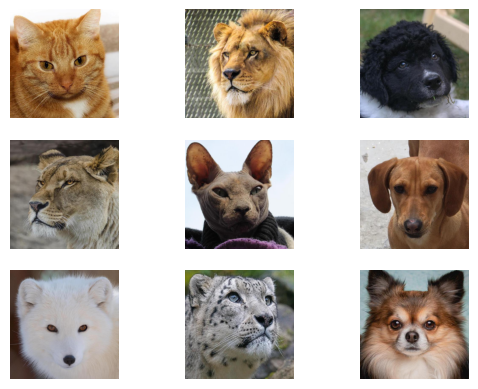

In [10]:
# Visualize some samples
n = 3
fig, ax = plt.subplots(n,n)
for row in range(n):
    for col in range(n):
        img = Image.open(df.sample(n=1)['image'].iloc[0]).convert('RGB')
        ax[row,col].imshow(img)
        ax[row, col].axis('off')
plt.show()

In [11]:
# Hyperparamters
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [12]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)

# **Model**

In [13]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) 
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) 
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2) 
      self.relu = nn.ReLU() 

      self.flatten = nn.Flatten() 
      self.linear = nn.Linear((128 * 16 * 16), 128)
      self.output = nn.Linear(128, len(df['label'].unique())) 


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) 
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [15]:
# Training
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.0717 Train Accuracy 79.8457
              Validation Loss: 0.3203 Validation Accuracy: 90.8884
Epoch 2/10, Train Loss: 1.3132 Train Accuracy 92.7253
              Validation Loss: 0.3162 Validation Accuracy: 90.9795
Epoch 3/10, Train Loss: 0.9367 Train Accuracy 94.7857
              Validation Loss: 0.2031 Validation Accuracy: 95.3075
Epoch 4/10, Train Loss: 0.6508 Train Accuracy 96.4847
              Validation Loss: 0.1514 Validation Accuracy: 95.8087
Epoch 5/10, Train Loss: 0.4498 Train Accuracy 97.5784
              Validation Loss: 0.1394 Validation Accuracy: 95.9909
Epoch 6/10, Train Loss: 0.3599 Train Accuracy 98.2619
              Validation Loss: 0.2421 Validation Accuracy: 94.0774
Epoch 7/10, Train Loss: 0.2755 Train Accuracy 98.5744
              Validation Loss: 0.1633 Validation Accuracy: 95.8998
Epoch 8/10, Train Loss: 0.2046 Train Accuracy 98.8966
              Validation Loss: 0.148 Validation Accuracy: 96.4009
Epoch 9/10, Train Loss: 0.1391 Tr

# **Evaluation**

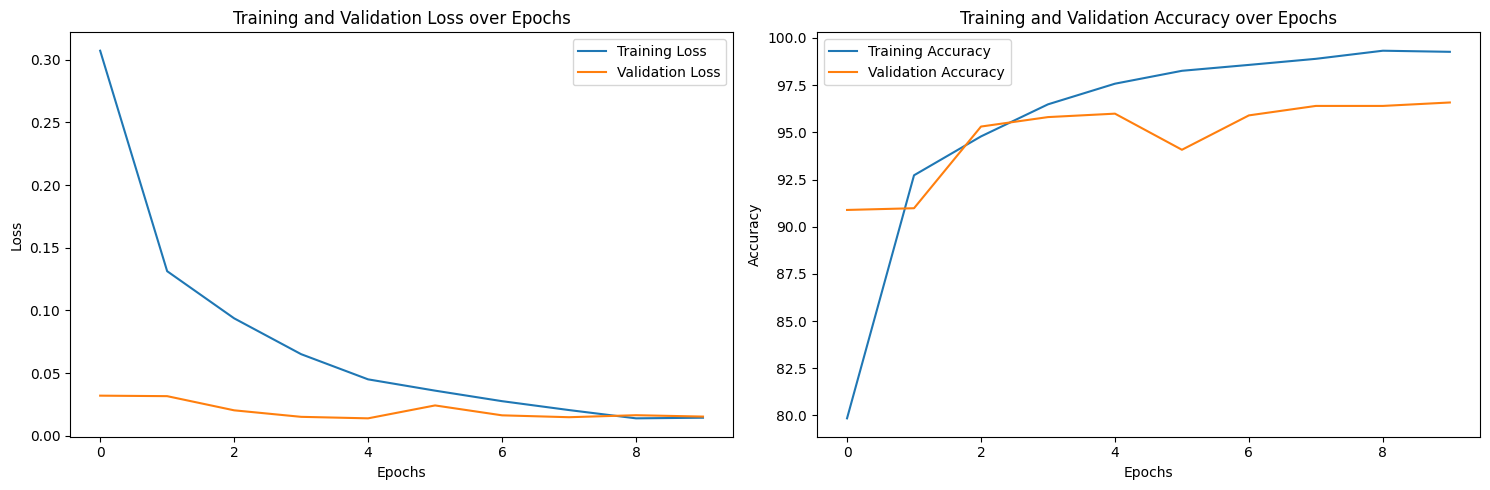

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [17]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, label in test_loader:
        predictions = model(inputs)
        acc = (torch.argmax(predictions, axis=1) == label).sum().item()
        total_acc_test += acc
        loss = criterion(predictions, label)
        total_loss_test += loss.item()
print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.217 and Loss is 0.0173


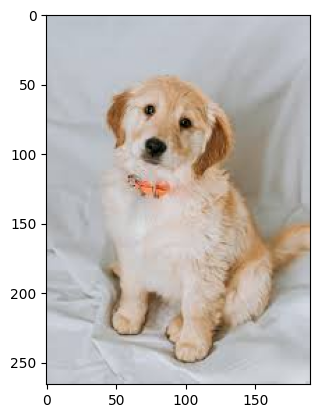


Prediction: 



array(['dog'], dtype=object)

In [18]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return le.inverse_transform([output])

## Visualize the image
image = Image.open("/kaggle/input/test-img/download.jpeg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/kaggle/input/test-img/download.jpeg")